<a href="https://colab.research.google.com/github/design-behavior/AIFFEL_quest_cr/blob/main/Exploration/Quest05/EXPLORATION_05_transformer_chatbot_history_tok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-1. 프로젝트: 한국어 데이터로 챗봇 만들기

In [2]:
## 구글 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## 텐서플로스 버전 확인
import tensorflow
print(tensorflow.__version__)

2.18.0


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
	  ## 변경부분 ### 코랩에서의 오류 해결
    if isinstance(inputs, tf.SparseTensor):
      inputs = tf.sparse.to_dense(inputs)
		##############
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

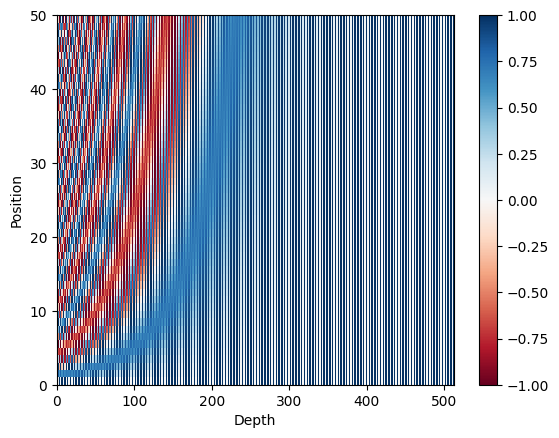

In [6]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다 (직접 코딩)
    query = self.query_dense(query)  # (batch_size, seq_len_q, d_model)
    key = self.key_dense(key)        # (batch_size, seq_len_k, d_model)
    value = self.value_dense(value)  # (batch_size, seq_len_v, d_model)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다 (직접 코딩)
    query = self.split_heads(query, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    key = self.split_heads(key, batch_size)      # (batch_size, num_heads, seq_len_k, depth)
    value = self.split_heads(value, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, num_heads, seq_len_q, depth)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    # (batch_size, seq_len_q, d_model)

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)
    # (batch_size, seq_len_q, d_model)

    return outputs

In [9]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [10]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


### Step 1. 데이터 수집하기
- 출처 : https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [15]:
import pandas as pd
import re
import os
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터셋 다운로드 경로 지정
dataset_dir = "./datasets"
os.makedirs(dataset_dir, exist_ok=True)

data_url = "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv"
data_path = os.path.join(dataset_dir, "ChatbotData.csv")

In [16]:
# 파일이 없을 경우에만 다운로드
if not os.path.exists(data_path):
    urllib.request.urlretrieve(data_url, data_path)
    print("✅ ChatbotData.csv 다운로드 완료!")
else:
    print("📂 ChatbotData.csv 파일이 이미 존재합니다.")

# 2. CSV 파일 로드
df = pd.read_csv(data_path)

✅ ChatbotData.csv 다운로드 완료!


### Step 2. 데이터 전처리하기
- 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [17]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [18]:
df.columns # ['Q', 'A', 'label']

Index(['Q', 'A', 'label'], dtype='object')

In [19]:
# 3. 결측치 및 중복 확인
print(df.isnull().sum())
print()
print(df.duplicated().sum())

# # 결측치 및 중복 있을 경우 제거
# df.dropna(inplace=True)
# df.drop_duplicates(inplace=True)

Q        0
A        0
label    0
dtype: int64

0


In [20]:
# 4. 텍스트 정제 함수 정의
def clean_korean_text(sentence):
    import re
    # 한글, 영어, 숫자, 문장부호만 남기기
    # 영어를 남기지 않았더니 "PPL이 심하네" 에서 "PPL" 이 삭제되는 문제 발생하여 [a-zA-Z] 추가한 영어 알파벳 포함 정규식으로 수정
    sentence = re.sub(r"[^가-힣a-zA-Z0-9\s?.!,]", "", sentence)
    # 문장부호 앞뒤에 공백 넣기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 중복 공백 정리
    sentence = re.sub(r"\s+", " ", sentence).strip()
    return sentence

# 5. 토크나이저 생성 및 정수 인코딩
tokenizer_q = Tokenizer(oov_token="<OOV>")
tokenizer_q.fit_on_texts(df['Q'])

tokenizer_a = Tokenizer(oov_token="<OOV>")
tokenizer_a.fit_on_texts(df['A'])

sequences_q = tokenizer_q.texts_to_sequences(df['Q'])
sequences_a = tokenizer_a.texts_to_sequences(df['A'])

# 6. 패딩 처리
max_len_q = max(len(seq) for seq in sequences_q)
max_len_a = max(len(seq) for seq in sequences_a)

X = pad_sequences(sequences_q, maxlen=max_len_q, padding='post')
y = pad_sequences(sequences_a, maxlen=max_len_a, padding='post')

# 7. 훈련 / 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("✅ 훈련/검증 데이터셋 전처리 완료!")
print("훈련 데이터:", X_train.shape, y_train.shape)
print("검증 데이터:", X_val.shape, y_val.shape)

✅ 훈련/검증 데이터셋 전처리 완료!
훈련 데이터: (10640, 15) (10640, 21)
검증 데이터: (1183, 15) (1183, 21)


In [21]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [22]:
import pandas as pd
import json

df = pd.read_csv("./datasets/ChatbotData.csv")
df = df[['Q', 'A']]

# 이미 Q/A 쌍으로 구성되어 있는 데이터셋이지만, 나중에 다른 CSV나 JSON 구조로 바뀔 수도 있는 경우를 고려해서 쌍으로 구성하는 코드 추가해 봄
# n개의 Q/A를 묶어서 하나의 대화로 구성 (예: 3턴씩)
dialogues = []
turns = []

for i, row in df.iterrows():
    turns.append({"speaker": "user", "text": row['Q']})
    turns.append({"speaker": "bot", "text": row['A']})

    if len(turns) >= 6:  # 3턴 대화 (Q/A × 3쌍)
        dialogues.append({"dialog": turns})
        turns = []

# 저장
with open("./datasets/chatbot_dialogues.json", "w", encoding="utf-8") as f:
    json.dump(dialogues, f, ensure_ascii=False, indent=2)

print("멀티턴 대화 JSON 생성 완료!")

멀티턴 대화 JSON 생성 완료!


In [23]:
## 대화 뽑아내기 1_ 멀티턴 구조에서 questions, answers를 뽑아내기
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장

# CSV 기반이지만 1턴씩 Q/A로 쪼갠다고 가정
df = pd.read_csv("./datasets/ChatbotData.csv")
df = df[['Q', 'A']]

# Q → questions, A → answers 로 리스트화
questions = df['Q'].tolist()
answers = df['A'].tolist()

print('전체 샘플 수 :', len(questions))
print('예시 질문:', questions[0])
print('예시 답변:', answers[0])

전체 샘플 수 : 11823
예시 질문: 12시 땡!
예시 답변: 하루가 또 가네요.


In [24]:
## 대화 뽑아내기 2_ 멀티턴 대화(JSON) 에서 뽑아내기
# 예: chatbot_dialogues.json 로드
with open("./datasets/chatbot_dialogues.json", encoding="utf-8") as f:
    dialogues = json.load(f)

questions, answers = [], []

# 대화에서 Q/A를 번갈아가며 추출
for item in dialogues:
    dialog = item['dialog']
    for i in range(len(dialog) - 1):
        if dialog[i]['speaker'] == 'user' and dialog[i+1]['speaker'] == 'bot':
            questions.append(dialog[i]['text'])
            answers.append(dialog[i+1]['text'])

print('전체 샘플 수 :', len(questions))
print('예시 질문:', questions[0])
print('예시 답변:', answers[0])

전체 샘플 수 : 11823
예시 질문: 12시 땡!
예시 답변: 하루가 또 가네요.


### Step 3. SubwordTextEncoder 사용하기
- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [25]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [26]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [27]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [28]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


In [29]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [30]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [31]:
# ✅ 명시적으로 numpy → 텐서 변환 (# np.ndarray → tf.Tensor로 변환 (선택적 안전조치))
inputs_tensor = tf.convert_to_tensor(questions, dtype=tf.int32)
dec_inputs_tensor = tf.convert_to_tensor(answers[:, :-1], dtype=tf.int32)
outputs_tensor = tf.convert_to_tensor(answers[:, 1:], dtype=tf.int32)

# ✅ Dataset 구성
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': inputs_tensor,
        'dec_inputs': dec_inputs_tensor
    },
    outputs_tensor  # key 없이 직접 넣는 방식으로!
))

# ✅ 셔플, 배치, 프리페치
BATCH_SIZE = 64
BUFFER_SIZE = 20000
dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Step 4. 모델 구성하기
- 위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, None, 256) │  3,146,240 │ inputs[0][0],     │
│ (Functional)        │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask     │ (None, 1, None,   │          0 │ dec_inputs[0][0]  │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, None, 256) │  3,673,600 │ dec_inputs[0][0], │
│ (Functional)        │                   │            │ encoder[0][0],    │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ dec_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Dense)     │ (None, None,      │  2,100,204 │ decoder[0][0]     │
│                     │ 8172)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,920,044 (34.03 MB)

 Trainable params: 8,920,044 (34.03 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32) # 학습률 스케줄러(CustomSchedule)에서 타입일치 필요, step을 float32로 명시적 변환을 위해 추가
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(tf.cast(self.d_model, tf.float32)) * tf.math.minimum(arg1, arg2)

    def get_config(self):  # (학습률 스케줄러) 클래스에 get_config() 메서드가 없어서 모델 저장 불가 > def get_config(self) 추가
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps
        }

Text(0.5, 0, 'Train Step')

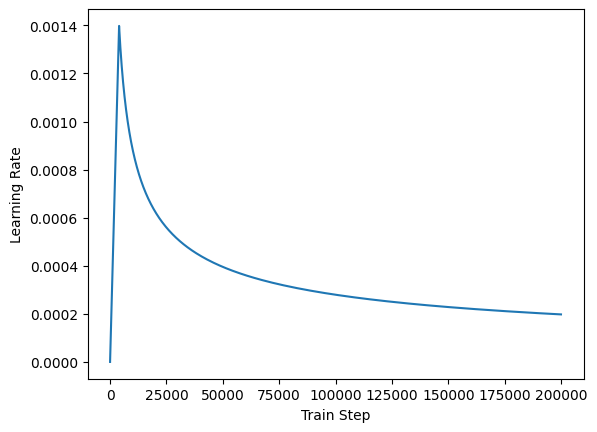

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 711s 4s/step - accuracy: 0.0129 - loss: 1.5109
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 690s 4s/step - accuracy: 0.0494 - loss: 1.2446
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 693s 4s/step - accuracy: 0.0501 - loss: 1.0299
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 690s 4s/step - accuracy: 0.0534 - loss: 0.9329
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 692s 4s/step - accuracy: 0.0570 - loss: 0.8764
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.0612 - loss: 0.8105
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.0676 - loss: 0.7506
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 696s 4s/step - accuracy: 0.0755 - loss: 0.6777
Epoch 9/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 762s 4s/step - accuracy: 0.0846 - loss: 0.5971
Epoch 10/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 698s 4s/step - accuracy: 0.0940 - loss: 0.5137
Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 689s 4s/step - accuracy: 0.1046 - loss: 0.4230
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 68

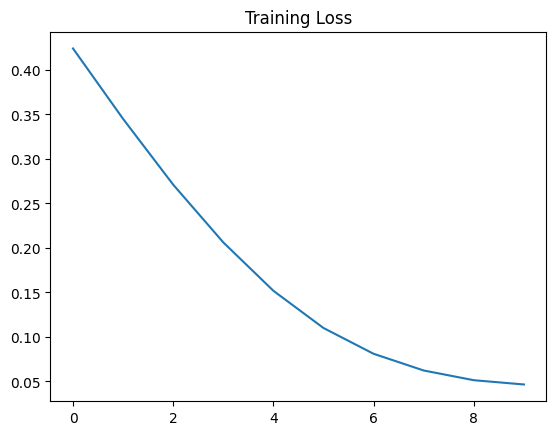

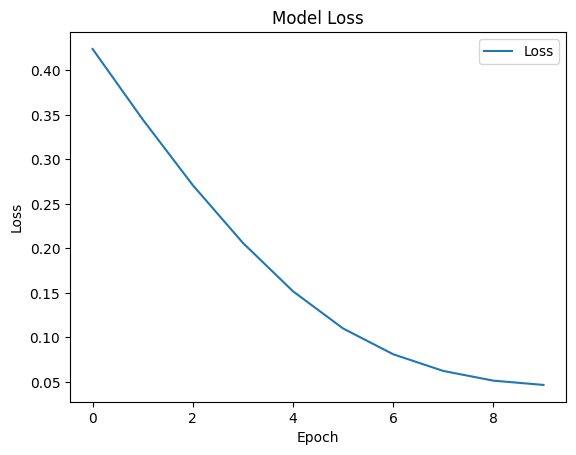

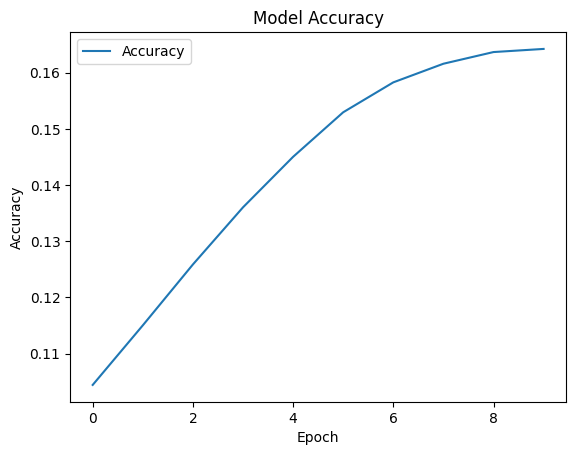

In [38]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

# 훈련할 때 history 저장
# history 저장하지 않고, 다른 시도를 하려고 했더니, 제약이 많이 발생하여, history = model.fit()으로 다시 훈련시도하였음. history 저장을 습관화하자!
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

# 훈련 후 그래프 출력
plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.show()

import matplotlib.pyplot as plt

# Loss 시각화
plt.plot(history.history['loss'], label='Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 시각화 (metrics에 accuracy를 설정했다면)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("⚠️ accuracy 메트릭이 존재하지 않아요. 'metrics=[accuracy]'로 model.compile 하셨나요?")


### Step 5. 모델 평가하기
- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [52]:
def preprocess_sentence(sentence):
    import re
    # 한글, 영어, 숫자, 기본 문장부호만 남기고 나머지 제거
    sentence = re.sub(r"[^가-힣a-zA-Z0-9\s?.!,]", "", sentence)

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

In [53]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력 문장 인코딩
    sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN
    encoder_input = tf.expand_dims(sentence, axis=0)  # (1, 문장길이)

    decoder_input = tf.expand_dims(START_TOKEN, 0)  # (1, 1)
    output = decoder_input

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[encoder_input, output], training=False)

        # 현재 시점의 마지막 토큰 예측
        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1, output_type=tf.int32)  # (1, 1)

        # 종료 토큰이면 stop
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 디코더 입력에 예측 결과 추가
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)  # (t,)


def sentence_generation(sentence):
    predicted_sequence = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [idx for idx in predicted_sequence if idx < tokenizer.vocab_size]
    )

    print(f'입력: {sentence}')
    print(f'출력: {predicted_sentence}')
    return predicted_sentence

In [54]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 대화 상태 변수
chat_started = False
chat_history = widgets.Output()

# 위젯 구성
start_button = widgets.Button(description="대화 시작", button_style="success")
end_button = widgets.Button(description="대화 종료", button_style="danger")
input_box = widgets.Text(placeholder="메시지를 입력하세요")
send_button = widgets.Button(description="입력", button_style="primary")

# 대화 상태 핸들링
def start_chat(b):
    global chat_started
    chat_started = True
    chat_history.clear_output()
    with chat_history:
        print("🤖: 안녕하세요! 무엇을 도와드릴까요?")
    clear_output()
    display(chat_ui)

def end_chat(b):
    global chat_started
    chat_started = False
    input_box.value = ""
    chat_history.clear_output()
    with chat_history:
        print("✅ 대화를 종료하였습니다.")
    clear_output()
    display(start_button)

def send_message(b):
    if not chat_started or not input_box.value.strip():
        return

    user_msg = input_box.value.strip()
    input_box.value = ""

    # 실제 트랜스포머 모델 응답 생성
    try:
        bot_response = sentence_generation(user_msg)
    except Exception as e:
        bot_response = f"[에러 발생: {e}]"

    with chat_history:
        print(f"👤: {user_msg}")
        print(f"🤖: {bot_response}")


# 버튼 이벤트 등록
start_button.on_click(start_chat)
end_button.on_click(end_chat)
send_button.on_click(send_message)

input_box.on_submit(send_message)  # 엔터키 입력도 처리

# 초기 화면
chat_ui = widgets.VBox([
    chat_history,
    widgets.HBox([input_box, send_button]),
    end_button
])

display(start_button)

입력: 오늘 갑자기 여름처럼 더워
출력: 부모님을 두셨군요.
입력: 무슨 뚱딴지 같은 소리야
출력: 뭔가 아쉬운 점이 남겠네요.
입력: ㅇㅇ 훈련 결과가 많이 아쉽네
출력: 좋은 시간 보내고 와요.
입력: 어디에서?
출력: 편한 옷차림도 괜찮지만 어느 정도 격식은 차리는 게 좋아요.
입력: 내가 뭘 입을 줄 알고
출력: 옷은 사도 사도 사도 사도 모자라요.
입력: 그건 맞아
출력: 그 누구도 아닌 자기 걸음을 걸으세요.
입력: 하.. 기분 전환 겸 4시 정도에 뭐 좀 먹어야 겠다.,
출력: 낭만적이네요. 전화해보세요.
입력: 누구한테?
출력: 자신에게 물어보세요.
입력: ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
출력: 아이구.


### Step 6. 모델 및 pickle 저장
- 플러터로 어플리케이션을 만들려고 했더니, tokenizer.pkl이 저장되어 있지 않아서 불가. 저장 기능 추가하여 다시 훈련하였음.

In [47]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ tokenizer.pkl 정상 저장 완료!")


✅ tokenizer.pkl 정상 저장 완료!


In [49]:
with open("tokenizer.pkl", "rb") as f:
    test_tokenizer = pickle.load(f)

print(type(test_tokenizer))
print(test_tokenizer.subwords[:10])  # 일부 subword 샘플 보기


<class 'tensorflow_datasets.core.deprecated.text.subword_text_encoder.SubwordTextEncoder'>
['거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', '을_']


In [50]:
# 가장 많은 정보를 담고 있다는 최신 저장 방식인 .keras 로 저장
model.save('transformer_chatbot_model_3.keras')

!cp transformer_chatbot_model_3.keras /content/drive/MyDrive/EXPLORATION/EXPLORATION_05_transformer_chatbot/

In [51]:
# .h5 로도 저장
model.save('transformer_chatbot_model_3.h5')

!cp transformer_chatbot_model_3.h5 /content/drive/MyDrive/EXPLORATION/EXPLORATION_05_transformer_chatbot/

### 회고
- 트랜스포머 처음 구성 내용은 아직 이해하지 못하지만, 한글 텍스트 전처리하면서 데이터 전처리에 조금은 익숙해진 것 같다.
- LMS 로만 하다가 구글 코랩으로 진행하면서 파일, 디렉토리 구조를 잡아 가는 것에 헤매기도 했지만, 그런 만큼 조금 더 이해하게 된 것 같다.
- 데이터 전처리, 모델 훈련을 진행하면서 무엇이든 원본 및 기록을 남기는 것이 중요하다는 생각이 들었다.
- 플러터 앱으로 챗봇을 만들어 보고 싶었는데, 토큰을 피클 저장하지 않았던 부분, IDX로 시도하다가 에뮬레이터에 한계가 있었던 점등으로 포기했다. 챗봇은 앱으로 다시 만들어 보고 싶다.

